# Imports

In [1]:
import dolfin as dl
import hippylib as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from spin.core import problem
from spin.fenics import converter
from spin.hippylib import hessian, laplace, misfit, optimization, prior

sns.set_theme(style="ticks")

# PDE Problem

In [ ]:
# Set up 1D mesh
mesh = dl.IntervalMesh(100, -1.5, 1.5)

# Define variational PDE problem in SPIN
problem_settings = problem.SPINProblemSettings(
    mesh=mesh,
    pde_type="mean_exit_time_moments",
    inference_type="drift_and_diffusion",
)
problem_builder = problem.SPINProblemBuilder(problem_settings)
spin_problem = problem_builder.build()

In [ ]:
# Set up ground truth
parameter_coordinates = spin_problem.coordinates_parameters
solution_coordinates = spin_problem.coordinates_variables
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]", "std::log(std::pow(x[0],2) + 2)"),
    spin_problem.function_space_parameters,
)
true_parameter = converter.convert_to_numpy(
    true_parameter.vector(), spin_problem.function_space_parameters
)
true_solution = spin_problem.solve_forward(true_parameter)

# Generate artificial data by perturbing the true solution
num_data_points = 50
noise_std = 0.01
rng = np.random.default_rng(seed=0)
data_indices_mfpt_1 = rng.integers(0, true_solution.shape[1], num_data_points)
data_indices_mfpt_2 = rng.integers(0, true_solution.shape[1], num_data_points)
data_locations_mfpt_1 = solution_coordinates[data_indices_mfpt_1]
data_locations_mfpt_2 = solution_coordinates[data_indices_mfpt_2]
data_values_mfpt_1 = true_solution[0, data_indices_mfpt_1]
data_values_mfpt_2 = true_solution[1, data_indices_mfpt_2]
noise_mfpt1 = rng.normal(loc=0, scale=noise_std, size=data_values_mfpt_1.size)
noise_mfpt2 = rng.normal(loc=0, scale=noise_std, size=data_values_mfpt_2.size)
data_values_mfpt_1 = data_values_mfpt_1 + noise_mfpt1
data_values_mfpt_2 = data_values_mfpt_2 + noise_mfpt2

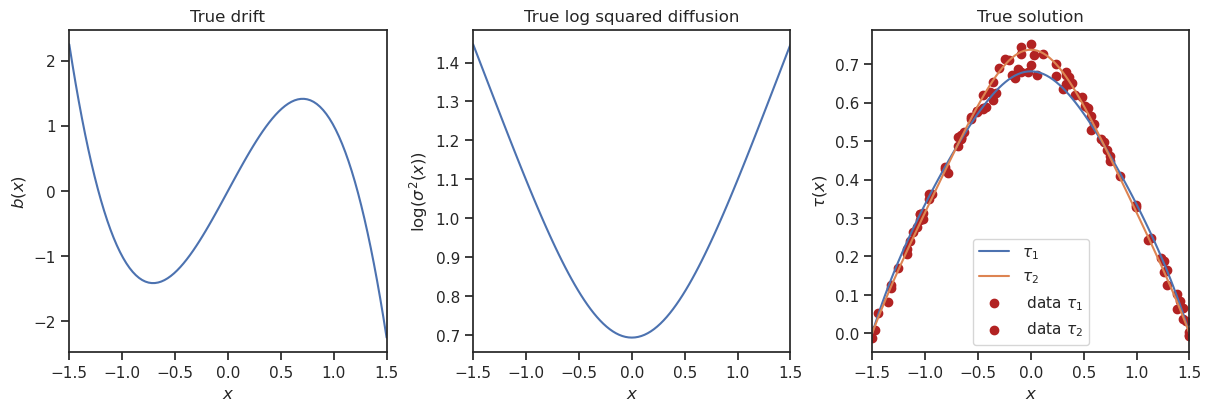

In [ ]:
# Plot ground truth with data
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")

# Drift
axs[0].plot(parameter_coordinates, true_parameter[0, :])
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")

# Diffusion
axs[1].plot(parameter_coordinates, true_parameter[1, :])
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True log squared diffusion")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\log(\sigma^2(x))$")

# Forward solution and data
axs[2].plot(solution_coordinates, true_solution[0, :], label=r"$\tau_1$")
axs[2].plot(solution_coordinates, true_solution[1, :], label=r"$\tau_2$")
axs[2].scatter(
    data_locations_mfpt_1, data_values_mfpt_1, color="firebrick", label=r" data $\tau_1$"
)
axs[2].scatter(
    data_locations_mfpt_2, data_values_mfpt_2, color="firebrick", label=r" data $\tau_2$"
)
axs[2].set_xlim(-1.5, 1.5)
axs[2].set_title("True solution")
axs[2].set_xlabel(r"$x$")
axs[2].set_ylabel(r"$\tau(x)$")
axs[2].legend()

# Prior

In [ ]:
# Set up SPIN prior
prior_settings = prior.PriorSettings(
    function_space=spin_problem.function_space_parameters,
    mean=("-x[0]", "1"),
    variance=("1", "0.05"),
    correlation_length=("1.5", "1.5"),
    robin_bc=True,
    robin_bc_const=3.0,
)
prior_builder = prior.BilaplacianVectorPriorBuilder(prior_settings)
spin_prior = prior_builder.build()
prior_variance = spin_prior.compute_variance_with_boundaries(
    method="Randomized", num_eigenvalues_randomized=50
)

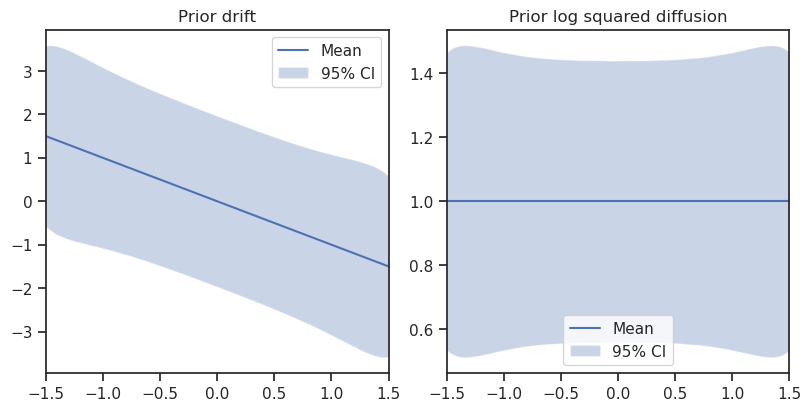

In [ ]:
# Plot prior mean and variance
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")

# Drift
axs[0].plot(parameter_coordinates, spin_prior.mean_array[0, :], label="Mean")
axs[0].fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array[0, :] - 1.96 * np.sqrt(prior_variance[0, :]),
    spin_prior.mean_array[0, :] + 1.96 * np.sqrt(prior_variance[0, :]),
    alpha=0.3,
    label="95% CI",
)
axs[0].set_title("Prior drift")
axs[0].set_xlim(-1.5, 1.5)
axs[0].legend()

# Diffusion
axs[1].plot(parameter_coordinates, spin_prior.mean_array[1, :], label="Mean")
axs[1].fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array[1, :] - 1.96 * np.sqrt(prior_variance[1, :]),
    spin_prior.mean_array[1, :] + 1.96 * np.sqrt(prior_variance[1, :]),
    alpha=0.3,
    label="95% CI",
)
axs[1].set_title("Prior log squared diffusion")
axs[1].set_xlim(-1.5, 1.5)
axs[1].legend()

# Misfit and Inference Model

In [ ]:
# Set up SPIN misfit
misfit_settings = misfit.MisfitSettings(
    function_space=spin_problem.function_space_variables,
    observation_points=(data_locations_mfpt_1, data_locations_mfpt_2),
    observation_values=(data_values_mfpt_1, data_values_mfpt_2),
    noise_variance=(
        noise_std**2 * np.ones(data_values_mfpt_1.shape),
        noise_std**2 * np.ones(data_values_mfpt_2.shape),
    ),
)
misfit_builder = misfit.MisfitBuilder(misfit_settings)
spin_misfit = misfit_builder.build()

In [ ]:
# Generate hippylib model from SPIN PDE problem, prior, and misfit
inference_model = hl.Model(
    spin_problem.hippylib_variational_problem,
    spin_prior.hippylib_prior,
    spin_misfit.hippylib_misfit,
)

# Optimization

In [ ]:
# Compute MAP point using Newton-CG solver
optimization_settings = optimization.SolverSettings(
    relative_tolerance=1e-8,
    absolute_tolerance=1e-12,
    max_num_line_search_iterations=50,
    armijo_line_search_constant=1e-4,
    verbose=True,
)
initial_guess = spin_prior.mean_array
newton_solver = optimization.NewtonCGSolver(optimization_settings, inference_model)
solver_solution = newton_solver.solve(initial_guess)
print("Termination reason:", solver_solution.termination_reason)


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    4.041948e+04    4.041898e+04    4.957568e-01   -7.785400e+05   1.969120e+06   1.000000e+00   5.000000e-01
  2   1    2.192357e+03    2.190906e+03    1.451157e+00   -8.009429e+04   2.853243e+05   1.000000e+00   3.806565e-01
  3   1    3.972489e+02    3.953494e+02    1.899451e+00   -3.624220e+03   3.696456e+04   1.000000e+00   1.370114e-01
  4   4    2.372613e+02    2.283259e+02    8.935386e+00   -8.776651e+02   2.639891e+03   5.000000e-01   3.661482e-02
  5   2    1.011434e+02    8.758814e+01    1.355525e+01   -3.175896e+02   6.307099e+03   1.000000e+00   5.659509e-02
  6   4    1.011434e+02    8.758814e+01    1.355525e+01   -2.006740e+02   2.572843e+03   9.094947e-13   3.614686e-02
  7   4    1.011434e+02    8.758814e+01    1.355525e+01   -2.006740e+02   2.572843e+03   8.881784e-16   3.614686e-02
Termination reason: Maximum number of backtracking reached


# Low-rank Hessian

In [ ]:
# Compute low-rank Hessian approximation using randomized SVD
hessian_settings = hessian.LowRankHessianSettings(
    num_eigenvalues=20,
    num_oversampling=30,
    inference_model=inference_model,
    evaluation_point=[
        solver_solution.forward_solution,
        solver_solution.optimal_parameter,
        solver_solution.adjoint_solution,
    ],
)
eigenvalues, eigenvectors = hessian.compute_low_rank_hessian(hessian_settings)

Text(0, 0.5, '$\\lambda_i$')

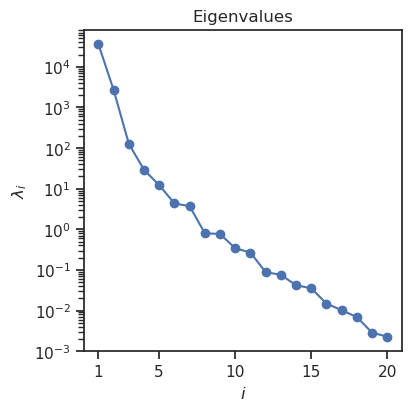

In [ ]:
# Plot Hessian eigenvalues
index_vector = np.arange(1, eigenvalues.size + 1)
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.semilogy(index_vector, eigenvalues, marker="o")
ax.set_title("Eigenvalues")
ax.set_xticks((1, 5, 10, 15, 20))
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\lambda_i$")

# Laplace Approximation

In [ ]:
# Construct Laplace approximation from MAP solution and low-rank Hessian approximation
laplace_approximation_settings = laplace.LowRankLaplaceApproximationSettings(
    inference_model=inference_model,
    mean=solver_solution.optimal_parameter,
    low_rank_hessian_eigenvalues=eigenvalues,
    low_rank_hessian_eigenvectors=eigenvectors,
)
laplace_approximation = laplace.LowRankLaplaceApproximation(laplace_approximation_settings)
posterior_variance = laplace_approximation.compute_pointwise_variance(
    method="Randomized", num_eigenvalues_randomized=200
)

posterior_predictive = spin_problem.solve_forward(solver_solution.optimal_parameter)

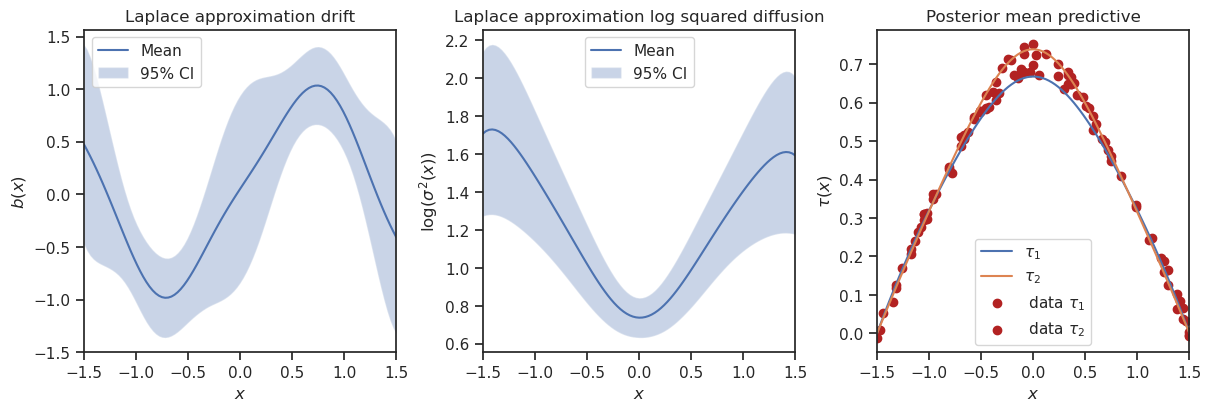

In [ ]:
# Visualize Laplace approximation and posterior predictive
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")

# Drift
axs[0].plot(parameter_coordinates, solver_solution.optimal_parameter[0, :], label="Mean")
axs[0].fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter[0, :] - 1.96 * np.sqrt(posterior_variance[0, :]),
    solver_solution.optimal_parameter[0, :] + 1.96 * np.sqrt(posterior_variance[0, :]),
    alpha=0.3,
    label="95% CI",
)
axs[0].set_title("Laplace approximation drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[0].set_xlim((-1.5, 1.5))
axs[0].legend()

#Diffusion
axs[1].plot(parameter_coordinates, solver_solution.optimal_parameter[1, :], label="Mean")
axs[1].fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter[1, :] - 1.96 * np.sqrt(posterior_variance[1, :]),
    solver_solution.optimal_parameter[1, :] + 1.96 * np.sqrt(posterior_variance[1, :]),
    alpha=0.3,
    label="95% CI",
)
axs[1].set_title("Laplace approximation log squared diffusion")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\log(\sigma^2(x))$")
axs[1].set_xlim((-1.5, 1.5))
axs[1].legend()

# Forward solution and data
axs[2].plot(solution_coordinates, posterior_predictive[0, :], label=r"$\tau_1$")
axs[2].plot(solution_coordinates, posterior_predictive[1, :], label=r"$\tau_2$")
axs[2].scatter(
    data_locations_mfpt_1, data_values_mfpt_1, color="firebrick", label=r" data $\tau_1$"
)
axs[2].scatter(
    data_locations_mfpt_2, data_values_mfpt_2, color="firebrick", label=r" data $\tau_2$"
)
axs[2].set_xlim(-1.5, 1.5)
axs[2].set_title("Posterior mean predictive")
axs[2].set_xlabel(r"$x$")
axs[2].set_ylabel(r"$\tau(x)$")
axs[2].legend()